In [23]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

In [24]:
ROOT_SUBMISSION = '/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/Submission/reference_models_result/'

MASKRCNN_DIR = os.path.join(ROOT_SUBMISSION, 'maskrcnn.csv')
FASTERRCNN_DIR = os.path.join(ROOT_SUBMISSION, 'fasterrcnn.csv')

YOLOV5_DIR = os.path.join(ROOT_SUBMISSION, 'yolov5.csv')
DETECTION2_DIR = os.path.join(ROOT_SUBMISSION, 'detectron2.csv')


In [25]:
maskrcnn_ss = pd.read_csv(MASKRCNN_DIR)
fasterrcnn_ss = pd.read_csv(FASTERRCNN_DIR)

yolov5_ss = pd.read_csv(YOLOV5_DIR)
detectron2_ss = pd.read_csv(DETECTION2_DIR)

In [26]:
PATH_TEST_DICOM = '/media/daitran/Data/Kaggle/VinBigData/test'

## ENSEMBLE

In [27]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

In [38]:
maskrcnn_ss

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.991 833 1180 1905 1650 11 0.921 595 307 93...
1,004f33259ee4aef671c2b95d54e4be68,0 0.99 1243 585 1533 898
2,008bdde2af2462e86fd373a445d0f4cd,0 0.996 1444 832 1728 1203 3 0.992 1129 1490 1...
3,009bc039326338823ca3aa84381f17f1,3 0.991 665 1096 1581 1385 0 0.939 993 493 121...
4,00a2145de1886cb9eb88869c85d74080,3 0.999 755 1307 1818 1650 0 0.979 1113 705 13...
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.994 1632 630 1884 936 3 0.992 1302 1422 23...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.994 1138 714 1426 1136 3 0.974 765 1434 16...
2997,ffaa288c8abca300974f043b57d81521,10 0.995 1672 1525 2338 2253
2998,ffc441e0c8b7153844047483a577e7c3,0 0.924 1002 654 1233 923 3 0.767 732 1327 149...


In [29]:
dicom_image_path = os.path.join(PATH_TEST_DICOM,maskrcnn_ss['image_id'][0] + '.dicom')

In [30]:
dicom_image_path

'/media/daitran/Data/Kaggle/VinBigData/test/002a34c58c5b758217ed1f584ccbcfe9.dicom'

In [31]:
test_image = dicom2array(dicom_image_path)

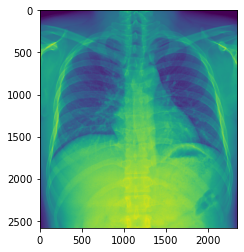

In [33]:
plt.imshow(test_image)
plt.show()

In [39]:
def getitem(dataframe, img_id):
    
    """
    Parameters
    ----------
    dataframe : pd.DataFrame
    img_id : str
        
    Returns
    -------
    Dictionary of radiographic observations
    """

    pred = list(dataframe.loc[dataframe.image_id == img_id, "PredictionString"])[0].split(' ')
    nb_elm = len(pred)//6
    output = {}
    
    for elm in range(nb_elm):
        output[f'elm_{elm}'] = pred[elm*6 : (elm+1)*6]
        
    return output


def sortDictByProba(dict_):
    
    """
    Parameters
    ----------
    dict_ : dict, Dictionary of radiographic observations
        
    Returns
    -------
    Dictionary of radiographic observations sorted by probabilities 
    """
    
    for key in dict_.keys():
        dict_[key] = list(map(lambda x: float(x), dict_[key]))
    
    # item[1][1] corresponds to the second element of the value (the confidence of the class identified)
    return {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1][1], reverse = True)}


def getHighestProba(*list_of_dicts, n=3):
    
    """
    Parameters
    ----------
    list_of_dicts : list[dict], List of dictionaries containing radiographic observations
    n : int, keep n highest elements of each list_of_dicts at most
    
    Returns
    -------
    Dict of merged top3 confidence interval in each dict of list_of_dicts
    """
    
    output = {}
    for index, dict_ in enumerate(list_of_dicts):
        dict_length = len(dict_)
        for i in range(dict_length):
            if i < n:
                output[f"elm_{i}_dict_{index}"] =list(dict_.values())[i]
                
    return output


def getUnique(dict_):
    
    """
    Parameters
    ----------
    dict_ : dict, Dictionary of radiographic observations
        
    Returns
    -------
    List of unique class_id, list of duplicates class_id
    """
    
    dict_length = len(dict_)
    
    classes_non_unique = [list(dict_.values())[index][0] for index in range(dict_length)]
    classes_unique = list(set(classes_non_unique))
    
    uniques, counts = np.unique(classes_non_unique, return_counts=True)
    duplicates = uniques[counts > 1]
    singles = np.setdiff1d(classes_unique, duplicates)
    
    return singles, duplicates


def getKeysByValue(dictOfElements, valueToFind):
    
    """
    Parameters
    ----------
    dictOfElements : dict, Dictionary of radiographic observations
    valueToFind : int, corresponds to class_id
    
    Returns
    -------
    List of keys of dictOfElements that contain valueToFind
    """
    
    output = list()
    listOfItems = dictOfElements.items()
    
    for item  in listOfItems:
        if item[1][0] == valueToFind:
            output.append(item[0])
            
    return  output


def getListKeysByValue(dictOfElements, valuesToFind):
    
    """
    Parameters
    ----------
    dictOfElements : dict, Dictionary of radiographic observations
    valuesToFind : list[int], list of class_id
    
    Returns
    -------
    List of lists of keys of dictOfElements for each value in valuesToFind
    """
    
    output = []
    
    for value in valuesToFind:
        output.append(getKeysByValue(dictOfElements, value))
        
    return output


def averaging(from_dict, single_keys, dupl_keys):
    
    """
    Parameters
    ----------
    from_dict : dict, dictionary to be filtered
    single_keys : list[str], list of keys that should be infered
    dupl_keys : list[str], list of class_id
    
    Returns
    -------
    A filtered dictionary with averaged probs and boxes
    """
    
    output = {}
    
    # Infer single keys
    if len(np.ravel(single_keys)) != 0:
        for single in np.ravel(single_keys):
            output[single] = from_dict[single]

    # For each duplicates, get index of all occurences and average boxing
    if len(np.ravel(dupl_keys)) != 0:
        for index, list_of_duplicate_class in enumerate(dupl_keys):
            probs = [] 
            boxing1 = []
            boxing2 = []
            boxing3 = []
            boxing4 = []
            
            for elm in list_of_duplicate_class:
                probs.append(from_dict[elm][1])
                boxing1.append(from_dict[elm][2])
                boxing2.append(from_dict[elm][3])
                boxing3.append(from_dict[elm][4])
                boxing4.append(from_dict[elm][5])
            
            output[f"elm_{index}"] = [from_dict[list_of_duplicate_class[0]][0],
                                      np.mean(probs),
                                      np.mean(boxing1),
                                      np.mean(boxing2),
                                      np.mean(boxing3),
                                      np.mean(boxing4)]
            
    return output


def toString(pred_list):
    
    """
    Parameters
    ----------
    list_final : list[int], list of all radiographic observations
    
    Returns
    -------
    A string which fits with the expected output
    """
    
    castedList = []
    for index, elm in enumerate(pred_list):
        if index%6 == 0:
            castedList.append(str(int(elm)))
        else:
            castedList.append(str(elm))
            
    output = " ".join(castedList)
    
    return output

In [46]:
def main():
    
    output = pd.DataFrame(columns = ["image_id", "PredictionString"])
    
    for image_id in tqdm(image_ids):
        
        # For each model, get PredictionString of image_id as a dict
        fasterrcnn_pred = getitem(fasterrcnn_ss, image_id)
        detectron_pred = getitem(detectron2_ss, image_id)
        yolo_pred = getitem(yolov5_ss, image_id)  
#         maskrcnn_pred = getitem(maskrcnn_ss, image_id)  
        
        # Sort dicts by proba
        sorted_fasterrcnn = sortDictByProba(fasterrcnn_pred)
        sorted_detectron = sortDictByProba(detectron_pred)
        sorted_yolo = sortDictByProba(yolo_pred)
#         sorted_maskrcnn = sortDictByProba(maskrcnn_pred)
        # Filter dicts into one dict with at most top n probs
        highest_probs = getHighestProba(sorted_fasterrcnn, 
                                        sorted_detectron, 
                                        sorted_yolo,
#                                         sorted_maskrcnn,
                                        n = 3)
        
        # Get keys of unique and duplicates values in the filtered dict
        singles, duplicates = getUnique(highest_probs)
        single_keys = getListKeysByValue(highest_probs, singles)
        dupl_keys = getListKeysByValue(highest_probs, duplicates)
        
        # Apply averaging strategy
        stacked_dict = averaging(highest_probs, single_keys, dupl_keys)
        
        # Put string in right format
        prediction_int = np.ravel(list(stacked_dict.values()))
        prediction_string = toString(prediction_int)
        
        output = output.append({"image_id": image_id, 
                                "PredictionString": prediction_string},
                               ignore_index=True)
        
    return output

In [47]:
image_ids = maskrcnn_ss.image_id.values

In [48]:
final_sub = main()

100%|██████████| 3000/3000 [00:09<00:00, 315.98it/s]


In [49]:
final_sub.to_csv("Submission/submission_5.2_4.csv", index=False)